# Draft Inundation duration notebook

## Pseudocode
- get flow data for the wetland of interest
- show map of wetland of interest
- set time period
- plot environmental flow data against observation dates

**What does this notebook do?** 

**Requirements:**

You need [data access](http://geoscienceaustralia.github.io/digitalearthau/connect/account.html#data-access) to the following [NCI projects](http://geoscienceaustralia.github.io/digitalearthau/connect/account.html#nci-account-registration) to run this notebook: `rs0` 

You need to run the following commands from the command line prior to launching jupyter notebooks from the same terminal so that the required libraries and paths are set:

`module use /g/data/v10/public/modules/modulefiles` 

`module load dea`

If you find an error or bug in this notebook, please either create an 'Issue' in the Github repository, or fix it yourself and create a 'Pull' request to contribute the updated notebook back into the repository (See the repository [README](https://github.com/GeoscienceAustralia/dea-notebooks/blob/master/README.rst) for instructions on creating a Pull request).

**Date:** July 2019

**Author:** Bex Dunn

#Fixme: update tags index

**Tags**: :index:`ITEM`, :index:`ITEM_confidence`, :index:`intertidal_zone`, :index:`masking`, :index:`query`, :index:`dc.load`, :index:`plot`

### load modules

In [1]:
import datacube
import datetime
import fiona
import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio.mask
import rasterio.features
from shapely import geometry
import seaborn as sns
import sys
import xarray as xr

from datetime import datetime, timedelta
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from textwrap import wrap

from datacube.storage import masking
from datacube.utils import geometry
from datacube.utils.geometry import CRS
from digitalearthau.utils import wofs_fuser

sys.path.append('/g/data/r78/rjd547/jupyter_notebooks/dea-notebooks/10_Scripts')
import DEADataHandling, DEAPlotting, TasseledCapTools, WetlandsTools

dc = datacube.Datacube(app='wetlands insight tool')
%load_ext autoreload
%autoreload 2

## define custom functions only used in this notebook

### specify input and output paths

In [2]:
#path to hydrograph data
flowdata = '/g/data/r78/rjd547/CEWO_Project/Data/flow_data_mac_marsh_2018/FlowData.xlsx'

In [3]:
#set output directory
global Output_dir
Output_dir = '/g/data/r78/rjd547/CEWO_Project/prototyping_outputs/'

In [4]:
#set polygon path
poly_path='/g/data/r78/rjd547/Ramsar_Wetlands/shapefiles/ExplodedRAMSAR.shp'

### define an area to work in

## get feature from shapefile to construct query

In [5]:
with fiona.open(poly_path) as shapes:
    #get crs object from polygon file
    crs = geometry.CRS(shapes.crs_wkt)
    for feature in shapes:
        #print (feature['id'])
        if feature['id'] == str(94): #matching this because I know the number for mac marshes
            #get feature geometry
            feature_geometry=feature['geometry']
            polyname =WetlandsTools.get_RAMSAR_polyName(feature)
            #print(polyname)
            #create datacube geometry.Geometry object
            geom = geometry.Geometry(feature_geometry, crs=crs)
            query = {'geopolygon': geom}#, 'time': ('2001-01-01', '2003-01-01') }# this should run for all time, if there is no time set?
            #load and mask data. selecting data with more than 90% clear for the geobox around the polygon... #FIXME

processing polygon The_Macquarie_Marshes-Macquarie_Marshes_Nature_Reserve-NSW-94


### show our area of interest on a map

In [6]:
# get the bounding box around the polygon in order to plot our area of interest
feature_bounding_box = geometry.Geometry(feature_geometry, crs=crs).boundingbox

In [7]:
#convert geometry from albers to geographic in order to plot on the web basemap
map_poly_geom =geom.to_crs(CRS('epsg:4326'))

In [9]:
import folium
from pyproj import Proj, transform
import math

# Define function to assist `display_map` in selecting a zoom level for plotting
def _degree_to_zoom_level(l1, l2, margin = 0.0):
    
    """
    Helper function to set zoom level for `display_map`
    """
    
    degree = abs(l1 - l2) * (1 + margin)
    zoom_level_int = 0
    if degree != 0:
        zoom_level_float = math.log(360 / degree) / math.log(2)
        zoom_level_int = int(zoom_level_float)
    else:
        zoom_level_int = 18
    return zoom_level_int

# def display_map(y, x, crs='EPSG:3577', margin=-0.5, zoom_bias=0):
y=(feature_bounding_box[1], feature_bounding_box[3])
x = (feature_bounding_box[0], feature_bounding_box[2])
crs='EPSG:3577'
margin=-0.5
zoom_bias=0

""" 
Given a set of x and y coordinates, this function generates an interactive map with a bounded 
rectangle overlayed on Google Maps imagery.        

Last modified: November 2018
Author: Robbi Bishop-Taylor

Modified from function written by Otto Wagner available here: 
https://github.com/ceos-seo/data_cube_utilities/tree/master/data_cube_utilities

Parameters
----------  
x : (float, float)
    A tuple of x coordinates in (min, max) format. 
y : (float, float)
    A tuple of y coordinates in (min, max) format.
crs : string, optional
    A string giving the EPSG CRS code of the supplied coordinates. The default is 'EPSG:3577'.
margin : float
    A numeric value giving the number of degrees lat-long to pad the edges of the rectangular overlay 
    polygon. A larger value results more space between the edge of the plot and the sides of the polygon.
    Defaults to -0.5.
zoom_bias : float or int
    A numeric value allowing you to increase or decrease the zoom level by one step. Defaults to 0; set
    to greater than 0 to zoom in, and less than 0 to zoom out.

Returns
-------
folium.Map : A map centered on the supplied coordinate bounds. A rectangle is drawn on this map detailing 
the perimeter of the x, y bounds.  A zoom level is calculated such that the resulting viewport is the
closest it can possibly get to the centered bounding rectangle without clipping it. 
"""
    
# Convert each corner coordinates to lat-lon
all_x = (x[0], x[1], x[0], x[1])
all_y = (y[0], y[0], y[1], y[1])        
all_longitude, all_latitude = transform(Proj(init=crs), Proj(init='EPSG:4326'), all_x, all_y) 

# Calculate zoom level based on coordinates 
lat_zoom_level = _degree_to_zoom_level(min(all_latitude), max(all_latitude), margin = margin) + zoom_bias
lon_zoom_level = _degree_to_zoom_level(min(all_longitude), max(all_longitude), margin = margin) + zoom_bias
zoom_level = min(lat_zoom_level, lon_zoom_level) 

# Identify centre point for plotting
center = [np.mean(all_latitude), np.mean(all_longitude)]

# Create map
interactive_map = folium.Map(location=center,
                             zoom_start=zoom_level,
                             tiles="http://mt1.google.com/vt/lyrs=y&z={z}&x={x}&y={y}",
                             attr="Google") 

# Create bounding box coordinates to overlay on map
line_segments = [(all_latitude[0], all_longitude[0]),
                 (all_latitude[1], all_longitude[1]),
                 (all_latitude[3], all_longitude[3]),
                 (all_latitude[2], all_longitude[2]),
                 (all_latitude[0], all_longitude[0])] 

# Add bounding box as an overlay
#interactive_map.add_child(folium.features.PolyLine(locations=line_segments,
                                        #           color='red', opacity=0.8))


interactive_map.add_child(folium.GeoJson(map_poly_geom.__geo_interface__))

In [74]:
marebone_gauge = pd.read_excel(flowdata, 
                        sheet_name='Sheet1', 
                        header=(2), 
                        parse_cols=('Date','Flow','NSWEW','CEW'),
                        index_col='Date',
                        parse_dates=True
                        )

In [80]:
#find maximum flow
marebone_gauge['CEW'].max()

2500.0

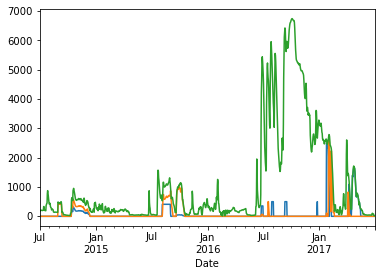

In [85]:
marebone_gauge['CEW'].plot()
marebone_gauge['NSWEW'].plot()
marebone_gauge['Flow'].plot()

### Create query from gauge data and area polygon

In [114]:
query = {'geopolygon': geom,
         'time': (marebone_gauge.index[0], marebone_gauge.index[-1]) #get first and last times for our query
         }

In [115]:
landsat_data = DEADataHandling.load_clearlandsat(dc,query)

Loading ls5
    Skipping ls5; no valid data for query
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls8
    Loading 67 filtered ls8 timesteps
Returning ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


In [121]:
### take a look at a timestep

In [126]:
landsat_data

<xarray.Dataset>
Dimensions:          (time: 67, x: 439, y: 651)
Coordinates:
  * time             (time) datetime64[ns] 2014-07-09T00:01:18 ... 2017-06-15T00:01:09.500000
  * y                (y) float64 -3.423e+06 -3.423e+06 ... -3.439e+06 -3.439e+06
  * x                (x) float64 1.465e+06 1.465e+06 ... 1.476e+06 1.476e+06
Data variables:
    coastal_aerosol  (time, y, x) float64 763.0 678.0 661.0 ... 603.0 604.0
    blue             (time, y, x) float64 806.0 709.0 656.0 ... 598.0 604.0
    green            (time, y, x) float64 1.104e+03 1.037e+03 ... 802.0 809.0
    red              (time, y, x) float64 1.362e+03 1.186e+03 ... 1.029e+03
    nir              (time, y, x) float64 2.265e+03 2.257e+03 ... 2.148e+03
    swir1            (time, y, x) float64 3.294e+03 3.024e+03 ... 3.325e+03
    swir2            (time, y, x) float64 2.605e+03 2.289e+03 ... 2.255e+03
    data_perc        (time, y, x) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
Attributes:
    crs:      EPSG:3577

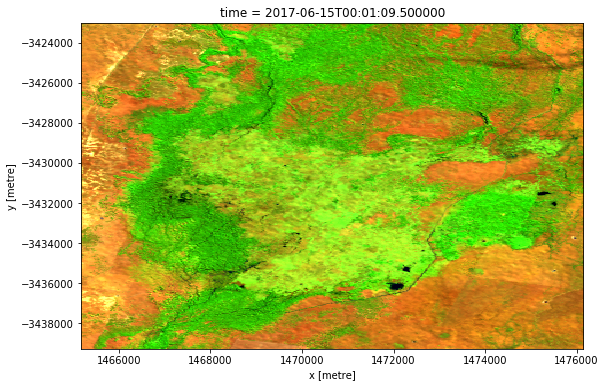

In [128]:
DEAPlotting.rgb(landsat_data.isel(time=-1), bands=['swir1','nir','green'])

In [136]:
landsat_data[
'time']

<xarray.DataArray 'time' (time: 67)>
array(['2014-07-09T00:01:18.000000000', '2014-07-25T00:01:20.000000000',
       '2014-08-10T00:01:30.000000000', '2014-08-26T00:01:32.000000000',
       '2014-09-11T00:01:36.000000000', '2014-09-27T00:01:33.500000000',
       '2014-10-13T00:01:40.000000000', '2014-10-29T00:01:37.000000000',
       '2014-11-14T00:01:41.000000000', '2014-11-30T00:01:39.000000000',
       '2014-12-16T00:01:34.000000000', '2015-01-01T00:01:28.500000000',
       '2015-01-17T00:01:28.000000000', '2015-02-02T00:01:24.000000000',
       '2015-02-18T00:01:16.000000000', '2015-03-06T00:01:10.000000000',
       '2015-03-22T00:01:00.500000000', '2015-04-07T00:00:50.000000000',
       '2015-04-23T00:00:48.000000000', '2015-05-09T00:00:32.000000000',
       '2015-05-25T00:00:31.000000000', '2015-06-10T00:00:42.000000000',
       '2015-06-26T00:00:47.000000000', '2015-07-12T00:00:58.500000000',
       '2015-07-28T00:01:04.000000000', '2015-08-13T00:01:08.500000000',
       '2015-0

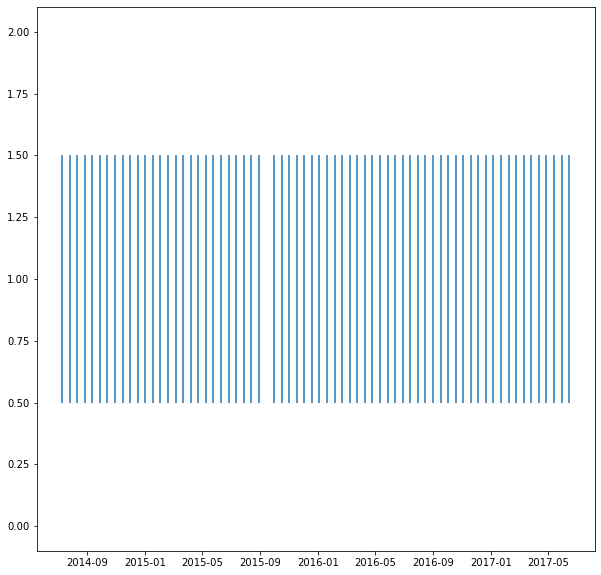

In [143]:
fig,axs = plt.subplots(1,1, figsize=(10,10))

axs.eventplot(landsat_data['time'].values)